# Bibliotecas

Nesta seção vamos instalar todas as bibliotecas utilizadas.

Além do OpenStreetMap, foram utilizadas: geopandas, pandas e networkx, mas estas já estão disponíveis no jupyter.

In [2]:
!pip install osmnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.5/100.5 kB 2.3 MB/s eta 0:00:00


# Preparação

Nesta seção, vamos preparar o grafo com os dados recolhidos [neste repositório](https://github.com/lemuel-manske/city-block/tree/main/data) e organizar vértices e arestas por bairro.

1. Gerar o grafo de Blumenau, cidade escolhida pela equipe para realizar o trabalho:

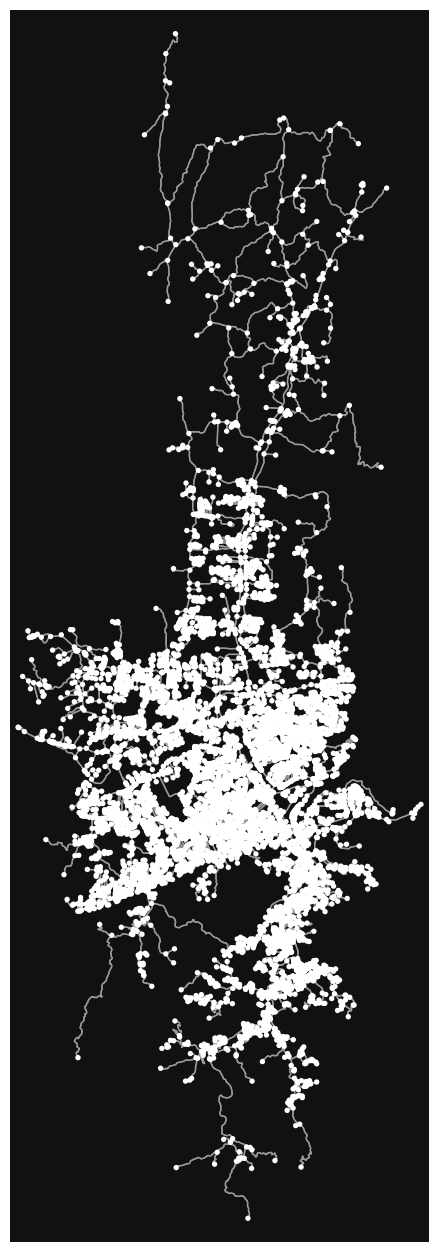

(<Figure size 1600x1600 with 1 Axes>, <Axes: >)

In [41]:
import networkx as nx
import osmnx as ox

PLACE = 'Blumenau, Brazil'

G: nx.MultiDiGraph = ox.graph_from_place(
    PLACE,
    network_type='drive'
)

ox.plot_graph(G, figsize=(16, 16))

2. Importar os dados recolhidos para o grafo. Para este processo, foram coletadas longitude - `x` - e latitude - `y` - de cada ponto de interesse e no grafo vamos atribuir um "label" e "nome" para o vértice mais próximo ao ponto de interesse desejado. Todos os datasets estão disponíveis [neste repositório](http://github.com/lemuel-manske/city-block/data)
  - https://osmnx.readthedocs.io/en/stable/user-reference.html#osmnx.distance.nearest_nodes

In [4]:
import pandas as pd
import networkx as nx

"""
  Labels with `label` the nodes of interest from a `dataframe` in a graph `G`.
"""
def label_points_of_interest(G: nx.MultiDiGraph, dataframe: pd.DataFrame, label: str):
  for idx, row in df.iterrows():
    x = row['x']
    y = row['y']
    name = row['name']

    nearest_node_from_interest_point = ox.distance.nearest_nodes(G, X=x, Y=y)

    G.nodes[nearest_node_from_interest_point]['name'] = name
    G.nodes[nearest_node_from_interest_point]['label'] = label

DATA_FRAMES = {
    'hospital': 'https://raw.githubusercontent.com/lemuel-manske/city-block/main/data/hospitals.csv',
}

for label, url in DATA_FRAMES.items():
  df = pd.read_csv(url)
  label_points_of_interest(G, df, label)

3. Afim de facilitar a análise, vamos separar todas os vértices e arestas por bairro. Foi necessário remover os bairros que não são reconhecidos na divisão administrativa feita pela prefeitura [neste link](https://www.blumenau.sc.gov.br/secretarias/secretaria-de-desenvolvimento-urbano/pagina/historia-sobre-municipio/divisa-administrativa-bairros) mas que o OSM reconhece.

  - https://osmnx.readthedocs.io/en/stable/user-reference.html#osmnx.features.features_from_place
  - https://wiki.openstreetmap.org/wiki/Key:admin_level

In [42]:
import osmnx as ox

PLACE = 'Blumenau, Brazil'

NOT_DESIRED_NEIGHBORHOODS = [
    'Belchior Baixo',
    'Belchior Alto',
    'Belchior Central',
    'Gaspar Alto',
    'Gaspar Grande',
    'Figueira',
    'Encano do Norte',
    'Encano Baixo',
    'Encano Central',
    'Encano Alto',
    'Sternthal',
    'Gruenerwinkel',
    'Planície Alta',
    'Treze de Maio',
    'Ribeirão Humberto',
    'Rio Bonito',
    'Terceiro Braço',
    'Sete de Janeiro',
]

neighborhood_tags = { 'admin_level': '10' }

neighborhoods = ox.features \
  .features_from_place(PLACE, { 'admin_level': '10' }) \
  .query(f'name not in {NOT_DESIRED_NEIGHBORHOODS}')

neighborhoods

type admin_level        boundary              name  \
element  id                                                                
relation 4066588  boundary          10  administrative        Bela Vista   
         4663904  boundary          10  administrative     Vila Itoupava   
         4663956  boundary          10  administrative  Itoupava Central   
         4665985  boundary          10  administrative     Itoupavazinha   
         4666040  boundary          10  administrative       Testo Salto   
         4666085  boundary          10  administrative         Badenfurt   
         4666090  boundary          10  administrative    Salto do Norte   
         4670953  boundary          10  administrative           Fidélis   
         4671087  boundary          10  administrative    Fortaleza Alta   
         4671197  boundary          10  administrative           Tribess   
         4671319  boundary          10  administrative         Fortaleza   
         4671330  boundary          10  administrative    Itoupava Norte   
         4672292  boundary          10  administrative    Nova Esperança   
         4672431  boundary          10  administrative       Ponta Aguda   
         4672598  boundary          10  administrative         Boa Vista   
         4672599  boundary          10  administrative     Victor Konder   
         4673271  boundary          10  administrative     Itoupava Seca   
         4673503  boundary          10  administrative         Vila Nova   
         4675352  boundary          10  administrative             Salto   
         4675392  boundary          10  administrative   Escola Agrícola   
         4675845  boundary          10  administrative   Salto Weissbach   
         4675989  boundary          10  administrative        Água Verde   
         4676377  boundary          10  administrative            Centro   
         4676425  boundary          10  administrative          Vorstadt   
         4681081  boundary          10  administrative       Passo Manso   
         4681115  boundary          10  administrative      Velha Grande   
         4681123  boundary          10  administrative     Velha Central   
         4681165  boundary          10  administrative             Velha   
         4681172  boundary          10  administrative        Bom Retiro   
         4681184  boundary          10  administrative   Jardim Blumenau   
         4681187  boundary          10  administrative      Vila Formosa   
         4681189  boundary          10  administrative        Valparaíso   
         4681234  boundary          10  administrative         Progresso   
         4681244  boundary          10  administrative            Glória   
         4681254  boundary          10  administrative            Garcia   
         4681255  boundary          10  administrative   Ribeirão Fresco   

                                                           geometry  \
element  id                                                           
relation 4066588  POLYGON ((-49.01859 -26.91568, -49.01777 -26.9...   
         4663904  POLYGON ((-49.08591 -26.74116, -49.08602 -26.7...   
         4663956  POLYGON ((-49.11388 -26.83523, -49.11357 -26.8...   
         4665985  POLYGON ((-49.13609 -26.85258, -49.13583 -26.8...   
         4666040  POLYGON ((-49.18496 -26.83577, -49.18479 -26.8...   
         4666085  POLYGON ((-49.1841 -26.88024, -49.18563 -26.87...   
         4666090  POLYGON ((-49.12871 -26.86938, -49.12821 -26.8...   
         4670953  POLYGON ((-49.08661 -26.85058, -49.08642 -26.8...   
         4671087  POLYGON ((-49.07305 -26.85982, -49.07373 -26.8...   
         4671197  POLYGON ((-49.06158 -26.8805, -49.06146 -26.88...   
         4671319  POLYGON ((-49.08358 -26.86216, -49.08325 -26.8...   
         4671330  POLYGON ((-49.08945 -26.87397, -49.08978 -26.8...   
         4672292  POLYGON ((-49.06252 -26.8857, -49.06245 -26.88...   
         4672431  POLYGON ((-49.06781 -26.91337, -49.06832 -26.9... 

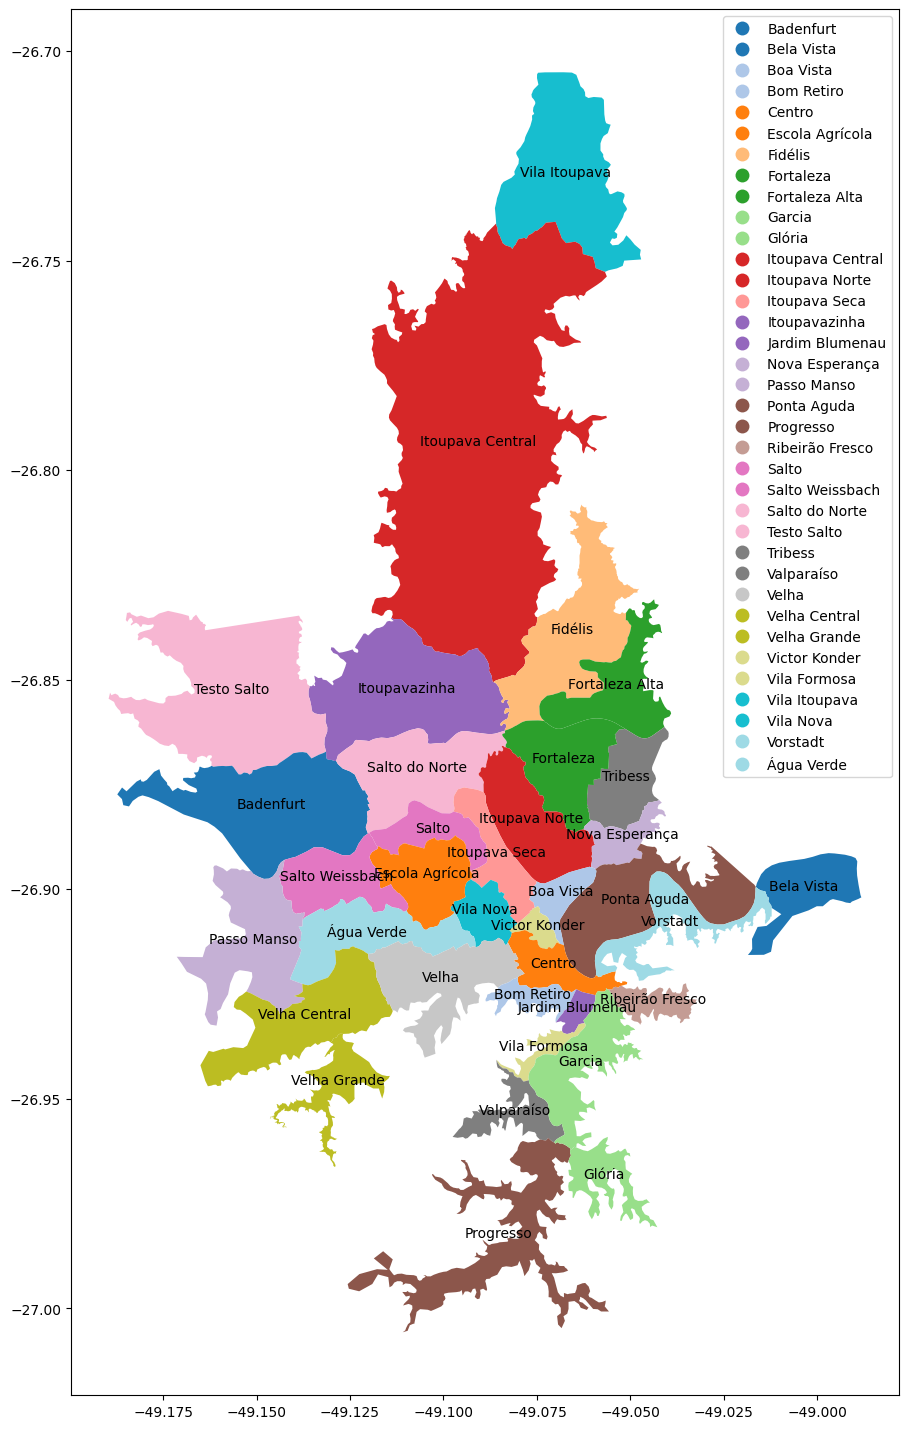

In [43]:
import matplotlib.pyplot as plt

neighborhoods.plot(column='name', cmap='tab20', legend=True, figsize=(12, 18))

neighborhoods.apply(lambda p: plt.annotate(text=p['name'], xy=p.geometry.centroid.coords[0], ha='center'), axis=1);

4. A partir da divisão por bairros, podemos combinar o grafo das vias com os polígonos dos bairros para permitir uma divisão das vias por bairro. Como exemplo, foi gerado um subgrafo do bairro Centro.

  - https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.html

  1. Primeiro, vamos adaptar a interface do OSM para ser compatível com o geopandas - que será responsável por combinar o grafo da cidade com os polígonos:

In [7]:
import osmnx as ox

G_nodes, G_edges = ox.graph_to_gdfs(G) # MultiDiGraph to GeoDataFrame

  2. Com o geopandas, podemos fazer um [*spatial join*](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.sjoin.html#geopandas.GeoDataFrame.sjoin) dos vértices - `G_nodes` - do grafo original que sobrepoem - `predicate='intersects'` - qualquer polígono - `neighborhoods[['geometry']]`.

  3. Por fim, renomeamos a coluna de `name_right` para `name` para manter consistência. A saída são todos os vértices de `G`, porém agora estão identificados por bairro.

In [34]:
import geopandas as gpd

nodes_with_neighborhood = gpd \
  .sjoin(G_nodes, neighborhoods[['name', 'geometry']], how='left', predicate='intersects') \
  .rename(columns={'name_right': 'name'})

nodes_with_neighborhood

,y,x,street_count,highway,name_left,label,junction,ref,geometry,element,id,name
osmid,,,,,,,,,,,,
262523380,-26.882776,-49.153530,3,NaN,NaN,NaN,NaN,NaN,POINT (-49.15353 -26.88278),relation,4666085.0,Badenfurt
262523850,-26.881833,-49.068869,4,NaN,NaN,NaN,NaN,NaN,POINT (-49.06887 -26.88183),relation,4671330.0,Itoupava Norte
262549487,-26.852528,-49.056115,3,NaN,NaN,NaN,NaN,NaN,POINT (-49.05612 -26.85253),relation,4671087.0,Fortaleza Alta
262550026,-26.860656,-49.054875,3,NaN,NaN,NaN,NaN,NaN,POINT (-49.05487 -26.86066),relation,4671319.0,Fortaleza
262550034,-26.851652,-49.056075,3,NaN,NaN,NaN,NaN,NaN,POINT (-49.05607 -26.85165),relation,4671087.0,Fortaleza Alta
...,...,...,...,...,...,...,...,...,...,...,...,...
12923714626,-26.858944,-49.055224,3,NaN,NaN,NaN,NaN,NaN,POINT (-49.05522 -26.85894),relation,4671087.0,Fortaleza Alta
12945511779,-26.884254,-49.077776,3,NaN,NaN,NaN,NaN,NaN,POINT (-49.07778 -26.88425),relation,4671330.0,Itoupava Norte
12945511780,-26.884325,-49.077816,3,NaN,NaN,NaN,NaN,NaN,POINT (-49.07782 -26.88432),relation,4671330.0,Itoupava Norte


5. Vamos modificar o grafo original `G` atribuindo a cada vértice seu respectivo bairro:

In [35]:
neighborhoods_dict = nodes_with_neighborhood['name'].to_dict()

nx.set_node_attributes(G, neighborhoods_dict, 'neighborhood_name')

6. E filtrando vértices do bairro "Centro", temos um subgrafo que representa o Centro de Blumenau:

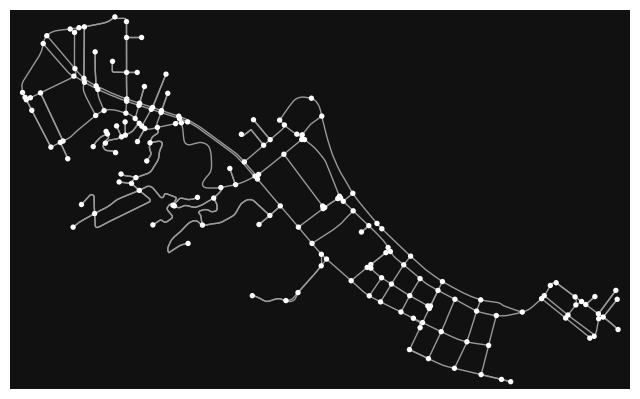

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [44]:
neighborhood_to_plot = ['Centro']

neighborhood_to_plot_nodes = nodes_with_neighborhood[nodes_with_neighborhood['name'].isin(neighborhood_to_plot)].index

G_neighborhood_to_plot = G.subgraph(neighborhood_to_plot_nodes).copy()

ox.plot_graph(G_neighborhood_to_plot)